### Cell 1: Imports & Setup

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

# Set visualization style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

### Cell 2: Load Enriched Data

In [10]:
# Load the data we processed in Task 1
df = pd.read_csv("../data/processed/ethiopia_fi_enriched.csv")

# Use format='mixed' to handle the different string formats automatically
df['observation_date'] = pd.to_datetime(df['observation_date'], format='mixed', errors='coerce')

# Create the year column, but handle rows where date might be NaT (Not a Time)
# This happens for impact_link records which often don't have specific dates
df['year'] = df['observation_date'].dt.year

# Filter out rows with no dates if we are doing temporal analysis
# but keep them in the main 'df' for schema/impact link analysis
print(f"Loaded {len(df)} records total.")
print(f"Records with valid dates: {df['observation_date'].notna().sum()}")

Loaded 60 records total.
Records with valid dates: 59


### Cell 3: Temporal Coverage Visualization

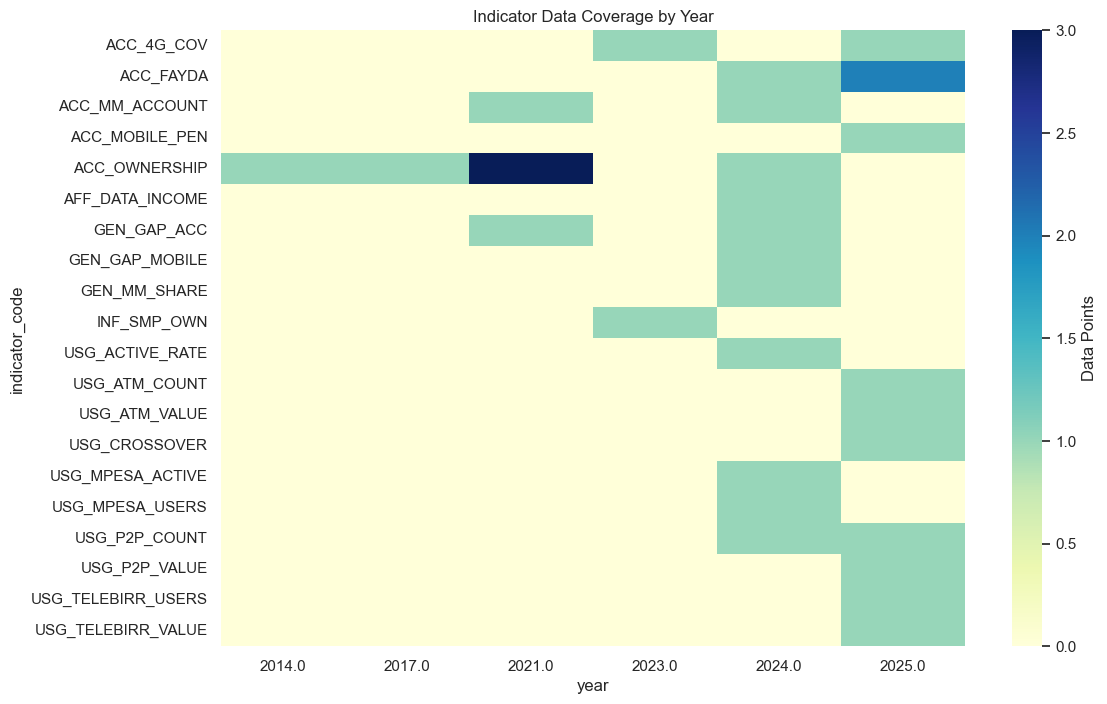

In [11]:
# Create a pivot to see which indicators have data in which years
coverage = df[df['record_type'] == 'observation'].pivot_table(
    index='indicator_code', 
    columns='year', 
    values='value_numeric', 
    aggfunc='count'
).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(coverage, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Data Points'})
plt.title("Indicator Data Coverage by Year")
plt.show()

### Cell 4: Access Analysis - The +3pp Slowdown

In [12]:
# Filter for Account Ownership
acc_ownership = df[df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')

fig = px.line(acc_ownership, x='observation_date', y='value_numeric', 
              title="Ethiopia Account Ownership Trajectory (2011-2024)",
              markers=True, labels={'value_numeric': '% of Adults', 'observation_date': 'Year'})

# Highlight the 2021-2024 period
fig.add_vrect(x0="2021-01-01", x1="2024-12-31", fillcolor="red", opacity=0.1, 
              annotation_text="The +3pp Slowdown Area")
fig.show()

### Cell 5: Usage (Digital Payments) vs. Access

In [13]:
# 1. Filter the specific indicators
# We include P2P Value to show the 'Usage' explosion
acc_df = df[df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')
mm_df = df[df['indicator_code'] == 'ACC_MM_ACCOUNT'].sort_values('observation_date')
p2p_df = df[df['indicator_code'] == 'USG_P2P_VALUE'].sort_values('observation_date')

# 2. Create figure with secondary y-axis
# Percentages on Left Y-axis, Currency/Volume on Right Y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add Account Ownership (Percentage)
fig.add_trace(
    go.Scatter(x=acc_df['observation_date'], y=acc_df['value_numeric'], 
               name="Bank Account Ownership (%)", line=dict(color='blue', width=4)),
    secondary_y=False,
)

# Add Mobile Money Penetration (Percentage)
fig.add_trace(
    go.Scatter(x=mm_df['observation_date'], y=mm_df['value_numeric'], 
               name="Mobile Money Accounts (%)", line=dict(color='orange', width=3)),
    secondary_y=False,
)

# Add P2P Transaction Value (Growth Volume)
fig.add_trace(
    go.Scatter(x=p2p_df['observation_date'], y=p2p_df['value_numeric'], 
               name="P2P Transfer Value (Usage Volume)", line=dict(color='green', dash='dot')),
    secondary_y=True,
)

# 3. Format the Layout
fig.update_layout(
    title_text="<b>The Paradox:</b> Stagnant Access vs. Exploding Usage (2011-2024)",
    hovermode="x unified",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_yaxes(title_text="<b>Percentage (%)</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Transaction Volume / Value</b>", secondary_y=True)

fig.show()

### Cell 6: Event Timeline Overlay

In [14]:
# Filter events
events = df[df['record_type'] == 'event'].sort_values('observation_date')
observations = df[df['record_type'] == 'observation']

fig = go.Figure()

# Plot core indicator (e.g., Mobile Money Users)
mm_users = observations[observations['indicator_code'] == 'ACC_MM_ACCOUNT']
fig.add_trace(go.Scatter(x=mm_users['observation_date'], y=mm_users['value_numeric'], 
                         mode='lines+markers', name='Mobile Money Acc (%)'))

# Add vertical lines for events
for i, row in events.iterrows():
    fig.add_vline(x=row['observation_date'], line_dash="dash", line_color="green")
    fig.add_annotation(x=row['observation_date'], y=max(mm_users['value_numeric']),
                       text=row['indicator'], showarrow=True, textangle=-45)

fig.update_layout(title="Impact of Events on Mobile Money Adoption", height=600)
fig.show()

### Cell 7: Gender Analysis:

In [15]:
# Analysis of Gender Gap
gender_df = df[df['indicator_code'].isin(['GEN_GAP_ACC', 'GEN_GAP_MOBILE'])].sort_values('observation_date')

if not gender_df.empty:
    fig_gender = px.bar(gender_df, x='observation_date', y='value_numeric', color='indicator_code',
                        barmode='group', title="Financial Inclusion Gender Gap Over Time")
    fig_gender.show()
else:
    print("No gender disaggregated data found in the current slice.")

### Cell 8: Data Quality Assessment

--- Data Quality Summary ---
Missing Dates: 1
Missing Values: 14
Low Confidence Records: 0
Records with no Pillar: 11


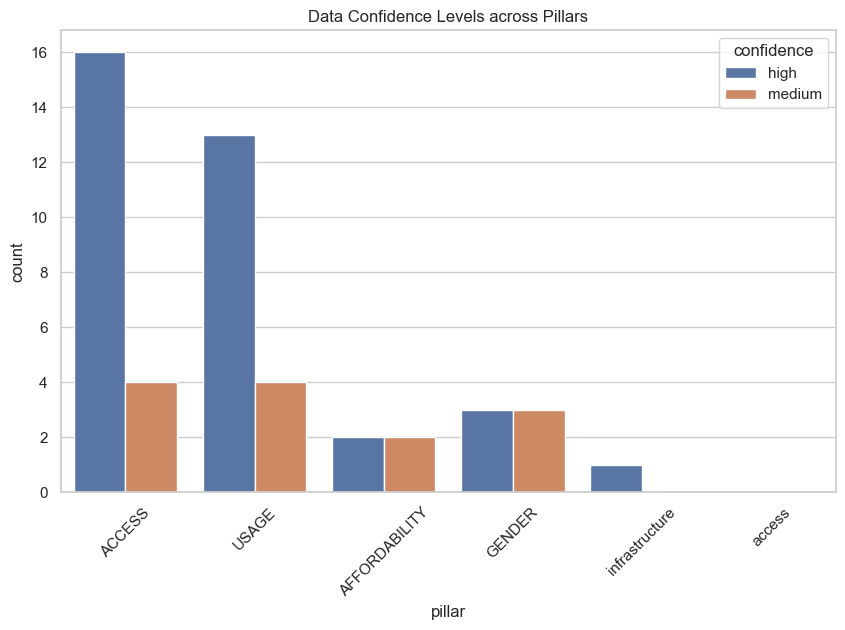

In [16]:
# Check for missing values in critical columns
quality_report = {
    "Missing Dates": df['observation_date'].isna().sum(),
    "Missing Values": df['value_numeric'].isna().sum(),
    "Low Confidence Records": len(df[df['confidence'] == 'low']),
    "Records with no Pillar": df['pillar'].isna().sum()
}

print("--- Data Quality Summary ---")
for key, value in quality_report.items():
    print(f"{key}: {value}")

# Visualize the breakdown of data quality by Pillar
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='pillar', hue='confidence')
plt.title("Data Confidence Levels across Pillars")
plt.xticks(rotation=45)
plt.show()